<a href="https://colab.research.google.com/github/vitaliy-sharandin/data_science_projects/blob/master/portfolio/regression/Energy_demand_based_on_weather.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Weather based energy demand prediction of Spain's major cities

This project uses energy demand information from major Spanish cities to predict cumulative energy consumption.

# Dataset
Spanish major cities energy consumption and weather dataset
* https://www.kaggle.com/datasets/nicholasjhana/energy-consumption-generation-prices-and-weather



In [1]:
!pip install -U -q datasets
!pip install -U -q ydata-profiling
!pip install -U -q feature_engine
!pip install -U -q Boruta
!pip install -U -q optuna
!pip install -U -q eli5
!pip install -U -q statsforecast
!pip install -U -q mlforecast
!pip install -U -q neuralforecast
!pip install -U -q datasetsforecast

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 9.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 357.5/357.5 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.8/395.8 kB 8.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.7/102.7 kB 5.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 679.5/679.5 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 296.5/296.5 kB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.7/4.7 MB 26.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 30.7 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into

# EDA


In [2]:
from datasets import load_dataset
from ydata_profiling import ProfileReport
import pandas as pd
from feature_engine.encoding import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import train_test_split
from boruta import BorutaPy
import xgboost as xgb
import optuna
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from datasetsforecast.losses import rmse
from statsforecast import StatsForecast
from statsforecast.models import AutoARIMA
from mlforecast import MLForecast
from sklearn.preprocessing import MinMaxScaler
from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoLSTM, AutoNHITS, AutoTFT
from neuralforecast.models import LSTM
from neuralforecast.losses.pytorch import DistributionLoss

In [3]:
energy_consumption_dataset = load_dataset("vitaliy-sharandin/energy-consumption-hourly-spain")
energy_consumption_weather_dataset = load_dataset("vitaliy-sharandin/energy-consumption-weather-hourly-spain")
energy_df = energy_consumption_dataset['train'].to_pandas()
weather_df = energy_consumption_weather_dataset['train'].to_pandas()

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Extracting data files:   0%|          | 0/1 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

## Energy dataset

In [4]:
energy_df['time'] = pd.to_datetime(energy_df['time'], errors="coerce", utc=True)
energy_df = energy_df.set_index('time')
energy_df.index = pd.to_datetime(energy_df.index,utc=True)
energy_df=energy_df.asfreq('h')

In [ ]:
profile = ProfileReport(energy_df, title="Energy data report", dark_mode=True)
profile.to_notebook_iframe()

In [6]:
def categorize_variables(target, df_train, cat_numeric_unique_threshold=10):
  target = target
  categorical_numeric = [var for var in df_train.columns if df_train[var].dtype!='O' and var!=target and df_train[var].nunique()<=cat_numeric_unique_threshold]
  continuous = [var for var in df_train.columns if df_train[var].dtype!='O' and var!=target and var not in categorical_numeric]
  mixed = [var for var in df_train.columns if pd.api.types.infer_dtype(df_train[var]) == 'mixed']
  categorical_object = [var for var in df_train.columns if df_train[var].dtype=='O' and var not in mixed]
  sorted_features = [target]+categorical_numeric+continuous+categorical_object+mixed
  print('Total columns: '+str(df_train.columns.size)+'\nColumns after sorting: '+str(len(sorted_features)))
  return target, categorical_numeric, continuous, mixed, categorical_object
target, categorical_numeric, continuous, mixed, categorical_object = categorize_variables('total load actual', energy_df)

Total columns: 28
Columns after sorting: 28


In [7]:
energy_df[target] = energy_df[target].interpolate(method='linear')
energy_df = energy_df[target].to_frame()

**Insights**
* We left target variable as the only one, because we want to predict solely based on weather.
* Target variable had several missing values, so we used linear interpolation to fill them.

## Target variable analysis

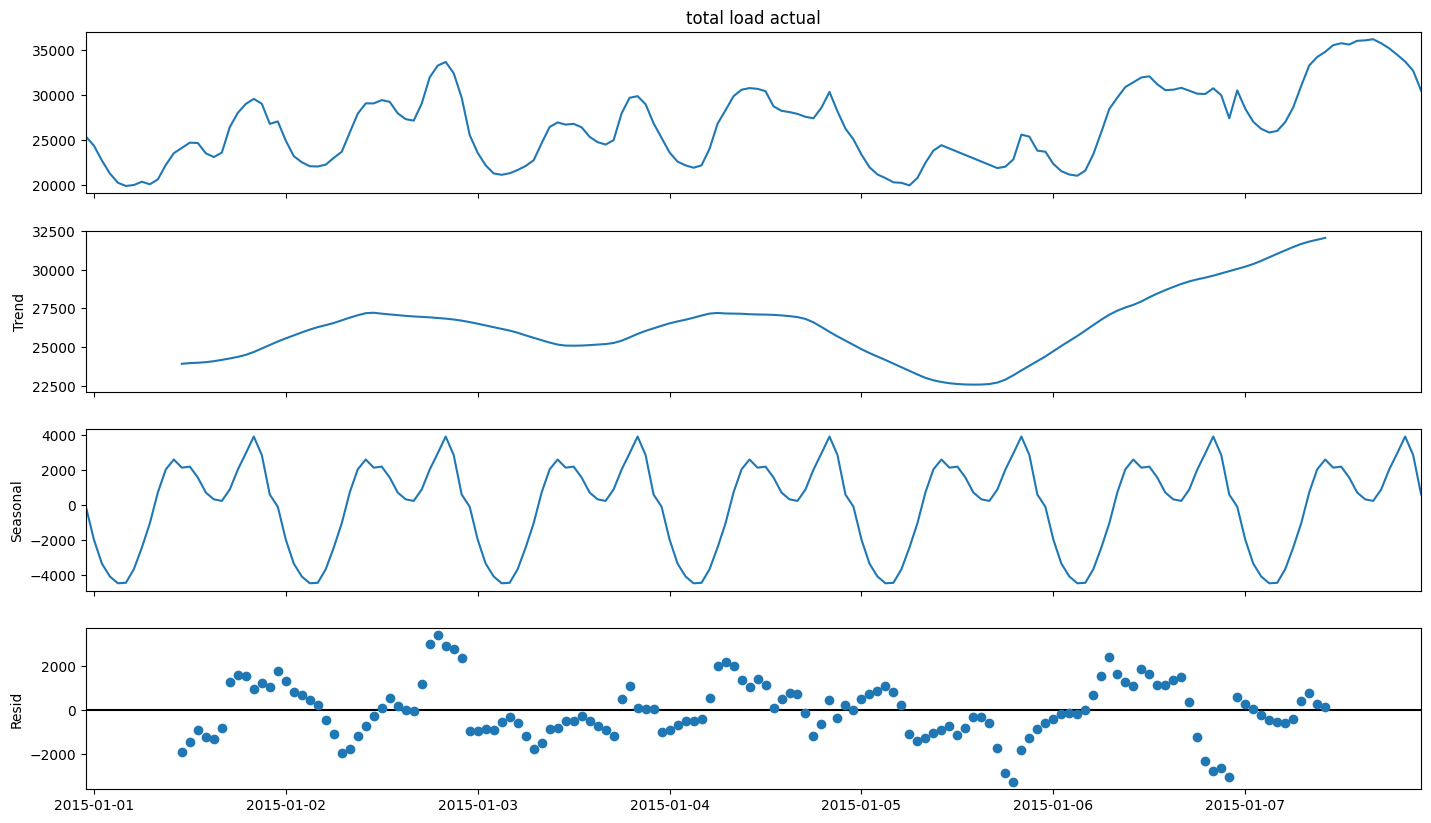

In [8]:
target_decompose = seasonal_decompose(energy_df[:168][target], model='additive')
plot = target_decompose.plot()
plot.set_size_inches((16, 9))
plt.show()

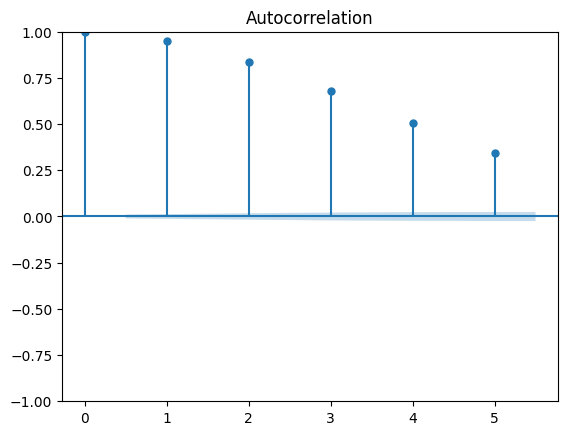

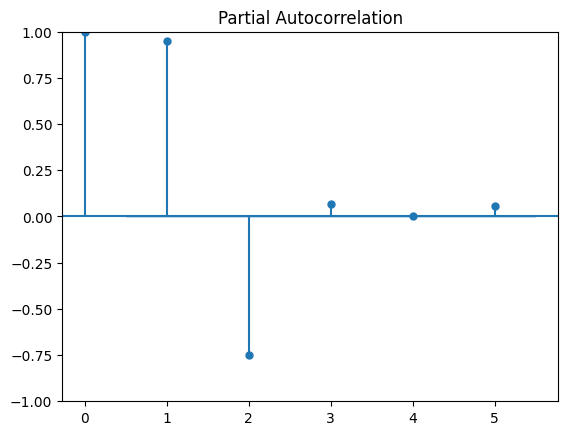

In [9]:
plot_acf(energy_df[target], lags=5)
plt.show()
plot_pacf(energy_df[target], lags=5)
plt.show()

**Insights**
* Series are non-stationary.
* Target variable has daily seasonality.
* The dataset has properties of AR process what stems from fast cutoff in PACF chart, this will become handy when we test ARIMA based models.

## Weather dataset EDA

In [10]:
weather_df['dt_iso'] = pd.to_datetime(weather_df['dt_iso'], utc=True)

In [ ]:
profile = ProfileReport(weather_df, title="Weather data report")
profile.to_notebook_iframe()

In [12]:
weather_df.drop(['rain_3h','weather_main','weather_icon'], axis=1, inplace=True)
weather_df = weather_df[weather_df['dt_iso'].isin(energy_df.index) & (~weather_df.duplicated(['dt_iso','city_name']))]

In [13]:
weather_df = weather_df.set_index(['dt_iso','city_name'])
weather_df = weather_df.unstack('city_name')
weather_df.columns = ['_'.join(col).strip() for col in weather_df.columns.values]

## Merging energy and weather dataset

In [14]:
energy_weather_df = energy_df.join(weather_df, how='inner')

# Feature selection and engineering

## Transforming variables

In [15]:
target, categorical_numeric, continuous, mixed, categorical_object = categorize_variables('total load actual', energy_weather_df)

train = energy_weather_df[:-168]
test = energy_weather_df[-168:]

encoder = OrdinalEncoder(
    variables=categorical_object,
    encoding_method='ordered'
)

train = encoder.fit_transform(train, train[target])
test = encoder.fit_transform(test, test[target])

Total columns: 61
Columns after sorting: 61


## Feature selection

In [16]:
from xgboost import XGBRegressor
import eli5

xgb = XGBRegressor()
xgb.fit(train[train.columns.difference([target])], train[target])

display(eli5.show_weights(xgb, feature_names = test[test.columns.difference([target])].columns.tolist(), top=60))

Weight,Feature
0.0787,humidity_Valencia
0.0384,humidity_Bilbao
0.0381,temp_ Barcelona
0.0371,humidity_ Barcelona
0.0265,temp_max_ Barcelona
0.0263,weather_id_Valencia
0.0245,humidity_Seville
0.0240,wind_deg_ Barcelona
0.0234,rain_1h_Bilbao
0.0230,weather_description_Bilbao


In [17]:
irrelevant_features = ['snow_3h_ Barcelona','snow_3h_Valencia','snow_3h_Seville','snow_3h_Madrid']
train = train[train.columns.difference(irrelevant_features)]
test = test[test.columns.difference(irrelevant_features)]

Every one of those even the least valuable variables will influence our selected model prediction results, therefore we will leave the all features whose predictive power is not 0.

# Model selection

I decided to use time series libraries from Nixtla for this project which both speed up training and make development process easier.

https://github.com/Nixtla

First, we transform data into statsforecast format and also order columns for statsforecast framework so that it can use them in the frameworks.

In [18]:
def transform_to_statsforecast_format(df):
  energy_weather_df_forecast = df.copy()
  energy_weather_df_forecast['unique_id'] = 'Energy_weather_Spain'
  energy_weather_df_forecast['ds'] = energy_weather_df_forecast.index.tz_localize(None)
  energy_weather_df_forecast = energy_weather_df_forecast.rename(columns={'total load actual':'y'})

  exogenous_variables = energy_weather_df_forecast.columns.difference(['unique_id', 'ds', 'y']).tolist()
  cols = ['unique_id', 'ds', 'y'] + exogenous_variables
  return energy_weather_df_forecast.reindex(columns=cols)

train_forecast = transform_to_statsforecast_format(train)
test_forecast = transform_to_statsforecast_format(test)

## ARIMA model test

Let's see how ARIMA with exogenous variables performs.

In [21]:
train_stats_forecast = transform_to_statsforecast_format(train)[-504:]
season_length = 24

models = [
    AutoARIMA(season_length=season_length)
]

sf = StatsForecast(
    models=models,
    freq='H',
    n_jobs=-1, verbose=True
)

crossvalidation_df = sf.cross_validation(
    df = train_stats_forecast,
    h = len(test_forecast.index),
    n_windows = 3
  )

rmse_value = crossvalidation_df.groupby(['unique_id', 'cutoff']).apply(lambda df: rmse(df['y'], df['AutoARIMA'])).mean()
display("AutoARIMA RMSE: "+str(rmse_value))

After 2 hours of training on only 3 week slice of data, AutoARIMA has shown RMSE=4473. In our context this is a pretty bad result, as our values are in ten of thousands and also very taxing in training time.

Now let's see how ARIMA performs without exogenous variables just using target values for training.

In [22]:
models = [
    AutoARIMA(season_length=season_length)
]

sf = StatsForecast(
    models=models,
    freq='H',
    n_jobs=-1, verbose=True
)

crossvalidation_df = sf.cross_validation(
    df = train_stats_forecast[['unique_id', 'ds', 'y']],
    h = len(test_forecast.index),
    n_windows = 3
  )

rmse_value = crossvalidation_df.groupby(['unique_id', 'cutoff']).apply(lambda df: rmse(df['y'], df['AutoARIMA'])).mean()
display("AutoARIMA RMSE: "+str(rmse_value))

Cross Validation Time Series 1:   0%|          | 0/3 [00:00<?, ?it/s]

'AutoARIMA RMSE: 3221.287'

As a result we can see that exogenous variables actually made case worse and without them AutoARIMA RMSE=3221.

## Tree model test

Here we will test two tree based regression models XGBRegressor and LGBMRegressor.

In [23]:
xgb = XGBRegressor()
lgbm = lgb.LGBMRegressor(verbose=-1)

ml_forecast = MLForecast(models=[xgb,lgbm],
                   freq='H',
                   lags=[1,2,3,12,24],
                   date_features=['hour','day','week'],
                   num_threads=6)

crossvalidation_df = ml_forecast.cross_validation(
    df=train_forecast[:],
    h=len(test_forecast.index),
    n_windows=3,
    static_features=[]
)

for model_name in ml_forecast.models:
  rmse_value = crossvalidation_df.groupby('cutoff').apply(lambda df: rmse(df['y'].reset_index(drop=True), df[str(model_name)].reset_index(drop=True))).mean()
  display(str(model_name)+" RMSE: "+str(rmse_value))

'XGBRegressor RMSE: 3082.93802557446'

'LGBMRegressor RMSE: 2989.668662214585'

We can see that tree models RMSE=3082 for XGB and RMSE=2989 for LGBM which is an improvement from ARIMA models.

## Deep learning model test

In [24]:
train_neural_forecast = transform_to_statsforecast_format(train)[-672:]


models = [LSTM(h=len(test_forecast.index),
               loss=DistributionLoss(distribution='Normal', level=[90]),
               max_steps=100,
               encoder_n_layers=2,
               encoder_hidden_size=200,
               context_size=10,
               decoder_hidden_size=200,
               decoder_layers=2,
               learning_rate=1e-3,
               scaler_type='standard',
               futr_exog_list=train_neural_forecast[train_neural_forecast.columns.difference(['unique_id', 'ds','y'])].columns.values.tolist()
               )
]

neural_forecast = NeuralForecast(models=models, freq='H')

crossvalidation_df = neural_forecast.cross_validation(
    df=train_neural_forecast,
    n_windows=3
)

for model_name in neural_forecast.models:
  rmse_value = crossvalidation_df.groupby(['unique_id', 'cutoff']).apply(lambda df: rmse(df['y'].reset_index(drop=True), df[str(model_name)].reset_index(drop=True))).mean()
  display(str(model_name)+" RMSE: "+str(rmse_value))

INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

'LSTM RMSE: 2220.9324060447275'

As we can see, the LSTM model performed the best in our case with RMSE=2280.  

**Insights**

After we have performed several tests on autoregressive, tree and deep learning models, we can conclude that the clear winner is LSTM deep learning model which also needs only last month of data vs whole dataset in tree models case. Yet we have taken LGBM without any hyperparameters, so let's see if this model will improve its results during hyperparamet optimization in competions with LSTM.

## Best model hyperparameters search

In [25]:
# %%time
# warnings.filterwarnings('ignore')

# def objective(trial):

#     model_name = trial.suggest_categorical("regressor", ['LSTM', 'LGBMRegressor'])

#     if model_name == "LGBMRegressor":
#       params = {
#         "objective": "regression",
#         "metric": "rmse",
#         "n_estimators": 1000,
#         "verbosity": -1,
#         "bagging_freq": 1,
#         "learning_rate": trial.suggest_float("learning_rate_light", 1e-3, 0.1, log=True),
#         "num_leaves": trial.suggest_int("num_leaves", 2, 2**10),
#         "subsample": trial.suggest_float("subsample_light", 0.05, 1.0),
#         "colsample_bytree": trial.suggest_float("colsample_bytree_light", 0.05, 1.0),
#         "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 1, 100),
#       }
#       model = lgb.LGBMRegressor(**params)

#       ml_forecast = MLForecast(models=[model],
#                     freq='H',
#                     lags=[1,2,12,24,168],
#                     date_features=['hour','day','week', 'month'],
#                     num_threads=6)

#       crossvalidation_df = ml_forecast.cross_validation(
#                                                         data=train_forecast,
#                                                         window_size=len(test_forecast.index),
#                                                         n_windows=3,
#                                                         static_features=[]
#                                                       )
#       rmse_value = crossvalidation_df.groupby(['unique_id', 'cutoff']).apply(lambda df: rmse(df['y'].reset_index(drop=True), df[str(model_name)].reset_index(drop=True))).mean()

#     elif model_name == "LSTM":
#       params = {
#       'encoder_n_layers': trial.suggest_int('encoder_n_layers', 1, 2),
#       'encoder_hidden_size': trial.suggest_categorical('encoder_hidden_size', [64, 128, 256]),
#       'decoder_layers': trial.suggest_int('decoder_layers', 1, 2),
#       'decoder_hidden_size': trial.suggest_categorical('decoder_hidden_size', [64, 128, 256]),
#       'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
#       'context_size': trial.suggest_int('context_size', 1, 60),
#       'scaler_type': trial.suggest_categorical('scaler_type', ['standard', 'robust'])
#       }

#       model = LSTM(h=len(test_forecast.index),
#                     loss=DistributionLoss(distribution='Normal', level=[90]),
#                     max_steps=100,
#                     encoder_n_layers=params['encoder_n_layers'],
#                     encoder_hidden_size=params['encoder_hidden_size'],
#                     context_size=params['context_size'],
#                     decoder_hidden_size=params['decoder_hidden_size'],
#                     decoder_layers=params['decoder_layers'],
#                     learning_rate=params['learning_rate'],
#                     scaler_type=params['scaler_type'],
#                     futr_exog_list=train_neural_forecast[train_neural_forecast.columns.difference(['unique_id', 'ds','y'])].columns.values.tolist()
#                     )

#       neural_forecast = NeuralForecast(models=[model], freq='H')

#       crossvalidation_df = neural_forecast.cross_validation(
#           df=train_neural_forecast,
#           n_windows=3
#       )

#       rmse_value = crossvalidation_df.groupby(['unique_id', 'cutoff']).apply(lambda df: rmse(df['y'].reset_index(drop=True), df[str(model_name)].reset_index(drop=True))).mean()

#     return rmse_value

# study = optuna.create_study(direction="minimize")
# study.optimize(objective, n_trials=20, show_progress_bar=True)

# display(study.best_params)
# display(study.best_value)

After several expreriments, LSTM is still the clear winner given amount of data needed for training, speed and lowest RMSE=1946 acheived. The hyperparameters we will use for final evaluation are:

```params = {
 'encoder_n_layers': 1,
 'encoder_hidden_size': 128,
 'decoder_layers': 1,
 'decoder_hidden_size': 128,
 'learning_rate': 0.001127440833670738,
 'context_size': 1,
 'scaler_type': 'standard'}```

# Final evaluation

In [26]:
params = { 'encoder_n_layers': 1,
          'encoder_hidden_size': 128,
           'decoder_layers': 1,
           'decoder_hidden_size': 128,
           'learning_rate': 0.001127440833670738,
           'context_size': 1,
           'scaler_type': 'standard'}

models = [LSTM(h=len(test_forecast.index),
               loss=DistributionLoss(distribution='Normal', level=[90]),
               max_steps=100,
               futr_exog_list=train_neural_forecast[train_neural_forecast.columns.difference(['unique_id', 'ds','y'])].columns.values.tolist(),
               **params
               )
]

neural_forecast = NeuralForecast(models=models, freq='H')

neural_forecast.fit(train_neural_forecast)
y_pred = neural_forecast.predict(futr_df=test_forecast[test_forecast.columns.difference(['y'])])

display("AutoLSTM RMSE: "+str(rmse(test_forecast['y'].reset_index(drop=True), y_pred['LSTM'].reset_index(drop=True))))

INFO:lightning_fabric.utilities.seed:Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

'AutoLSTM RMSE: 2998.5367724238445'

In [27]:
StatsForecast.plot(test_forecast, y_pred, models=['LSTM'], engine='plotly')

# Summary
In this project we have predicted energy use based on weather a week ahead achieving great results.

Such project opens opportunities for energy providers to optimize their energy supply chains, allowing for more efficient use of resources and potentially lowering costs. It also provides valuable data for policy makers in crafting more effective energy conservation measures. Moreover, this predictive model can be integrated into smart grid systems for real-time adjustments to energy distribution based on weather forecasts, improving both sustainability and reliability.

Additionally, the project's predictive model offers strategic insights for projects focused on substituting regular energy sources with alternative, renewable options. By accurately predicting energy consumption patterns in relation to weather conditions, planners can more effectively determine the optimal mix of traditional and renewable energy sources. This enables a smoother transition to greener energy solutions by identifying when and how much alternative energy can be integrated into the grid to meet demand, thereby reducing reliance on fossil fuels and lowering greenhouse gas emissions.